In [1]:
import common

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import random

random.seed(123)
np.random.seed(123)

In [4]:
# s, v0, k, t0
data = common.preparePistonDataset()
data

,milliseconds,group,x1,x2,x3,x4
0,60.226485,1,-1.0,-1.0,-1.0,-1.0
1,65.020360,1,-1.0,-1.0,-1.0,-1.0
2,57.302374,1,-1.0,-1.0,-1.0,-1.0
3,50.978262,1,-1.0,-1.0,-1.0,-1.0
4,56.526159,1,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...
155,68.963006,32,0.0,0.0,0.0,0.0
156,51.328098,32,0.0,0.0,0.0,0.0
157,51.372896,32,0.0,0.0,0.0,0.0
158,59.049678,32,0.0,0.0,0.0,0.0


In [5]:
main_terms = 'x1 + x2 + x3 + x4'
main_terms_significant = 'x1 + x2 + x3'
interaction_terms = 'x1:x2 + x1:x3 + x2:x3'
quadratic_terms = 'I(x1**2) + I(x2**2) + I(x3**2)'
formula_main = f'milliseconds ~ {main_terms}'
formula_interaction = f'milliseconds ~ {main_terms_significant} + {interaction_terms}'
formula_quadratic = f'milliseconds ~ {main_terms_significant} + {quadratic_terms}'
formula_full = f'milliseconds ~ {main_terms_significant} + {interaction_terms} + {quadratic_terms}'
group = ['x1', 'x2', 'x3', 'x4']

In [6]:
results = {
    'ols_main': common.buildModel(data, formula_main),
    'ols_interaction': common.buildModel(data, formula_interaction),
    'ols_quadratic': common.buildModel(data, formula_quadratic),
    'ols_full': common.buildModel(data, formula_full),
}
results['ols_main'].summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,63.6518,0.823,77.302,0.000,62.025,65.278
x1,-15.5256,0.951,-16.329,0.000,-17.404,-13.647
x2,13.0152,0.951,13.689,0.000,11.137,14.893
x3,4.7356,0.951,4.981,0.000,2.857,6.614
x4,0.3212,0.951,0.338,0.736,-1.557,2.199


In [7]:
results['ols_full'].summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,60.3069,1.197,50.397,0.000,57.942,62.671
x1,-15.5256,0.788,-19.709,0.000,-17.082,-13.969
x2,13.0152,0.788,16.523,0.000,11.459,14.572
x3,4.7356,0.788,6.012,0.000,3.179,6.292
x1:x2,-4.9101,0.965,-5.089,0.000,-6.816,-3.004
x1:x3,-2.2820,0.965,-2.365,0.019,-4.188,-0.376
x2:x3,1.6966,0.965,1.759,0.081,-0.210,3.603
I(x1 ** 2),4.5094,0.708,6.370,0.000,3.111,5.908
I(x2 ** 2),0.2682,0.708,0.379,0.705,-1.131,1.667
I(x3 ** 2),-0.3178,0.708,-0.449,0.654,-1.717,1.081


In [8]:
# How often does bootstrap analysis remove whole groups
from collections import Counter
ngroups = len(set(data['group']))
missing = []
for _ in range(10_000):
    missing.append(ngroups - len(set(data.sample(frac=1, replace=True)['group'])))
(np.array([Counter(missing).get(n, 0) for n in range(5)]) / len(missing)).round(3)

array([0.814, 0.172, 0.013, 0.001, 0.   ])

# Bootstrap analysis

In [9]:
methods = {
    'BA': (common.bootstrapAnalysis, False),
    'BBA': (common.befittingBootstrapAnalysis, True),
    'pBBA': (common.parametricBefittingBootstrapAnalysis, True),
    'pBA': (common.parametricBootstrapAnalysis, False),
    'wBA': (common.wildBootstrapAnalysis, False),
}

def compareMethods(results, nrepeats):
    for key, (method, require_group) in methods.items():
        kwargs = {'nrepeats': nrepeats}
        if require_group:
            kwargs['group'] = group
        results.update({
            f'{key}_main': method(data, formula_main, **kwargs),
            f'{key}_interaction': method(data, formula_interaction, **kwargs),
            f'{key}_quadratic': method(data, formula_quadratic, **kwargs),
            f'{key}_full': method(data, formula_full, **kwargs),
        })
    return results

results = compareMethods(results, 100)


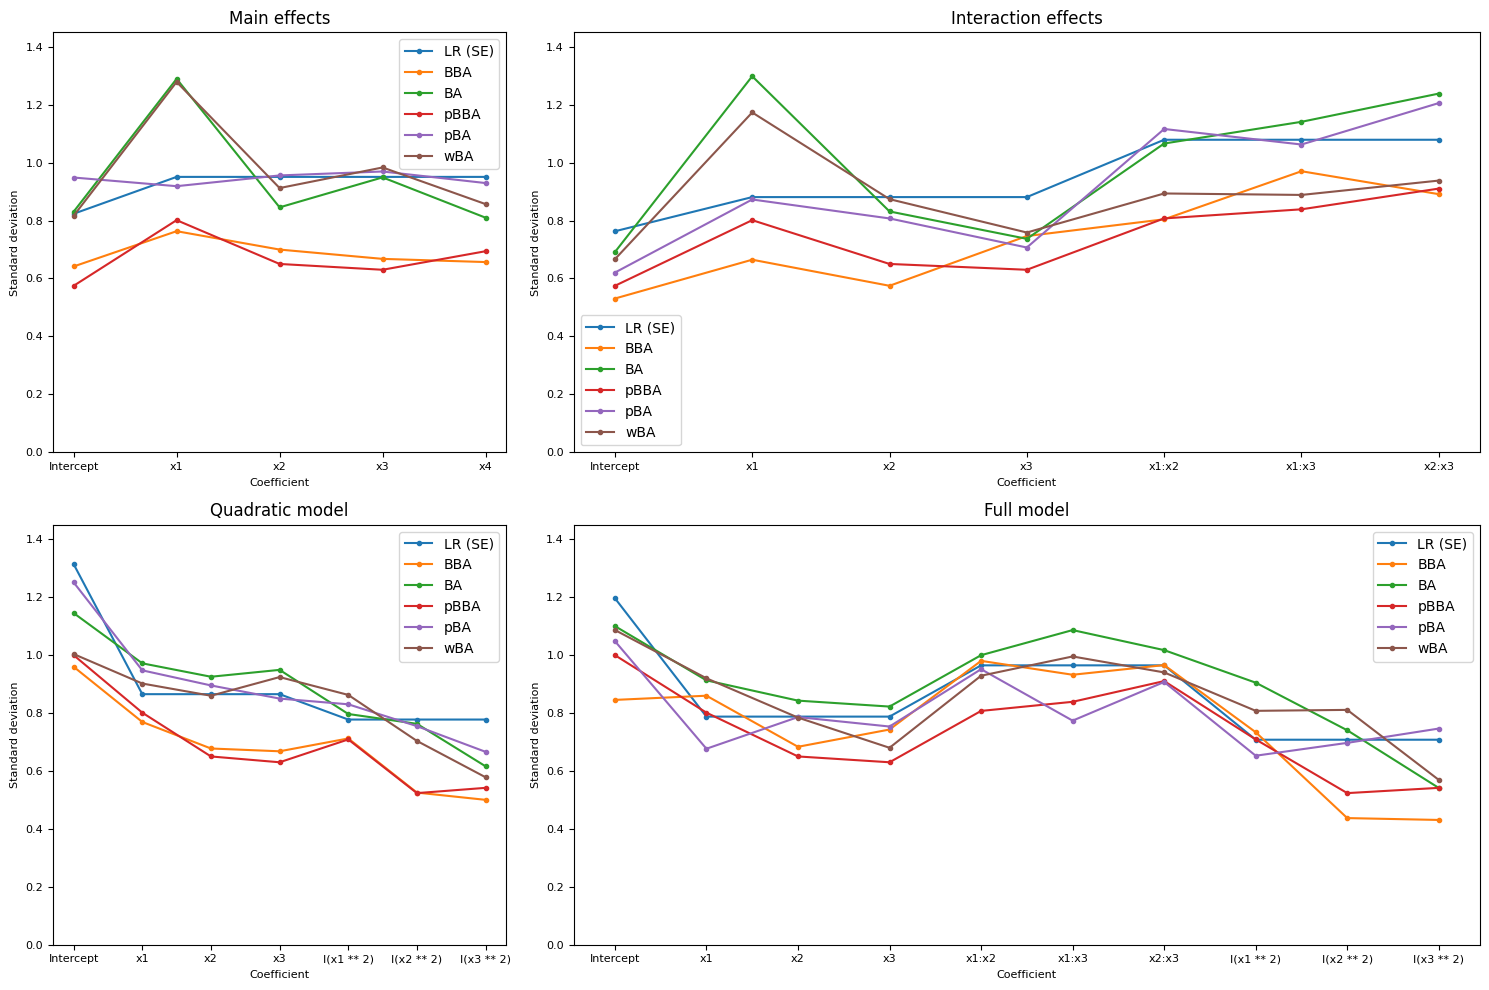

In [10]:
import itertools
def summary_std_cofficients(results, plot_std_coefficients = common.plot_std_coefficients):
    yrange = (0, 1000*0.00145)
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10), width_ratios=[1, 2])
    axes = list(itertools.chain(*axes))

    ax = plot_std_coefficients(results['ols_main'], results['BBA_main'], results['BA_main'], 
                                    results['pBBA_main'], results['pBA_main'], results['wBA_main'], 
                                    ax=axes[0])
    ax.set_ylim(yrange)
    ax.set_title('Main effects')
    ax = plot_std_coefficients(results['ols_interaction'], results['BBA_interaction'], results['BA_interaction'], 
                                    results['pBBA_interaction'], results['pBA_interaction'], results['wBA_interaction'], 
                                    ax=axes[1])
    ax.set_ylim(yrange)
    ax.set_title('Interaction effects')
    ax.legend()
    ax = plot_std_coefficients(results['ols_quadratic'], results['BBA_quadratic'], results['BA_quadratic'], 
                                    results['pBBA_quadratic'], results['pBA_quadratic'], results['wBA_quadratic'], 
                                    ax=axes[2])
    ax.set_ylim(yrange)
    ax.set_title('Quadratic model')
    ax.legend()
    ax = plot_std_coefficients(results['ols_full'], results['BBA_full'], results['BA_full'], 
                                    results['pBBA_full'], results['pBA_full'], results['wBA_full'], 
                                    ax=axes[3])
    ax.set_ylim(yrange)
    ax.set_title('Full model')
    ax.legend()
    plt.tight_layout()
summary_std_cofficients(results)
common.saveFigure('piston-std.pdf')


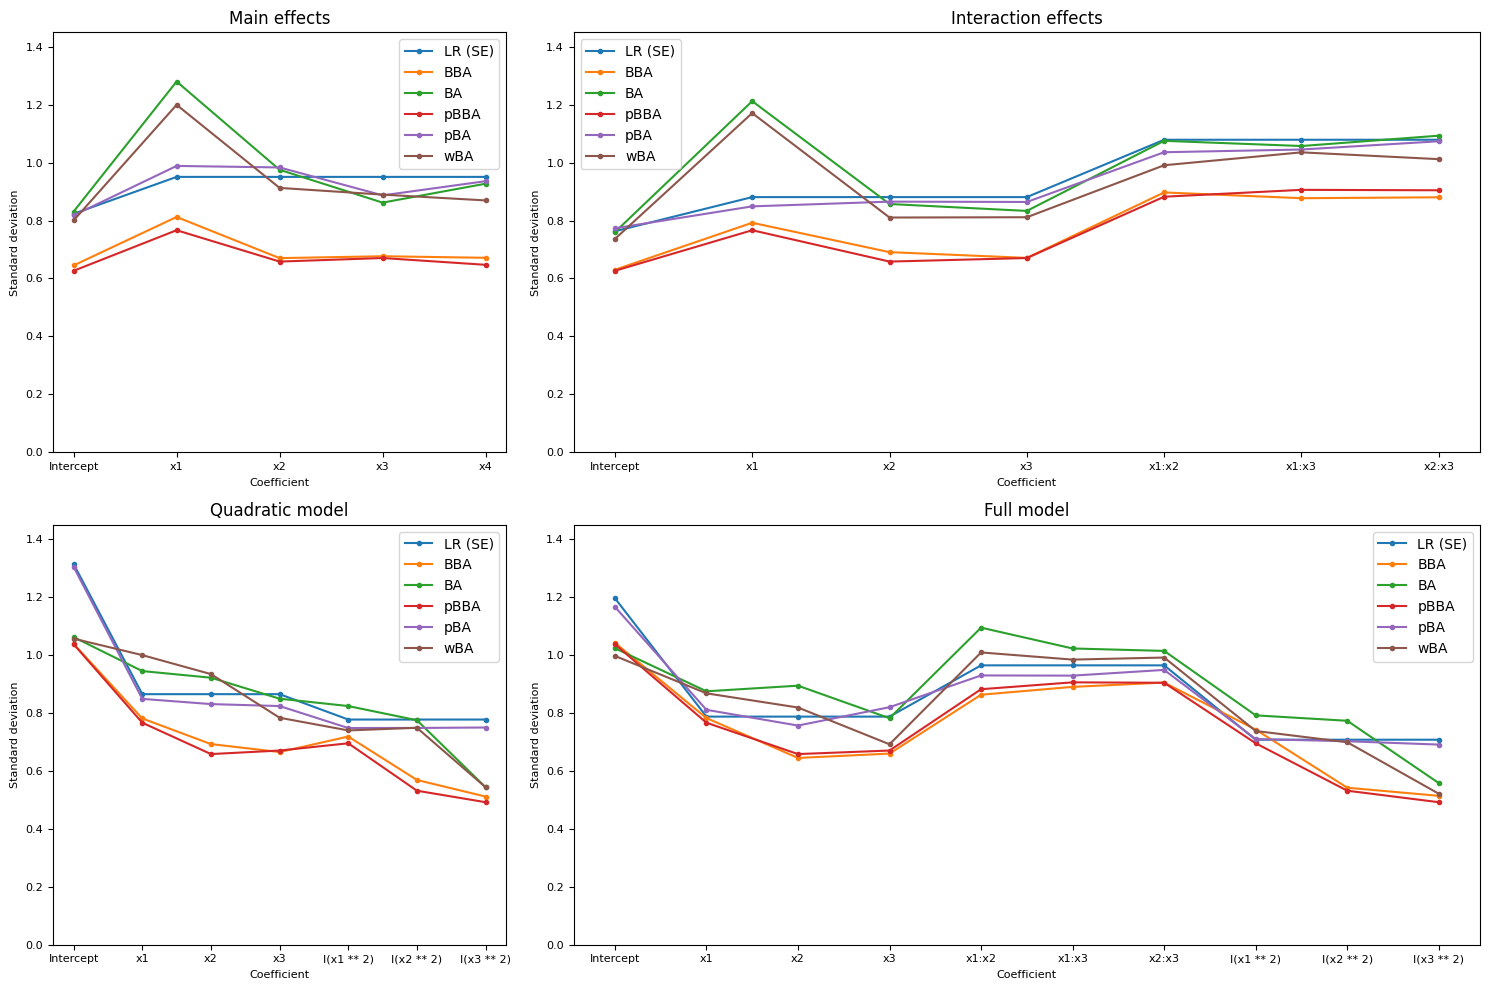

In [11]:
results = compareMethods(results, 500)

summary_std_cofficients(results)
common.saveFigure('piston-std-500.pdf')


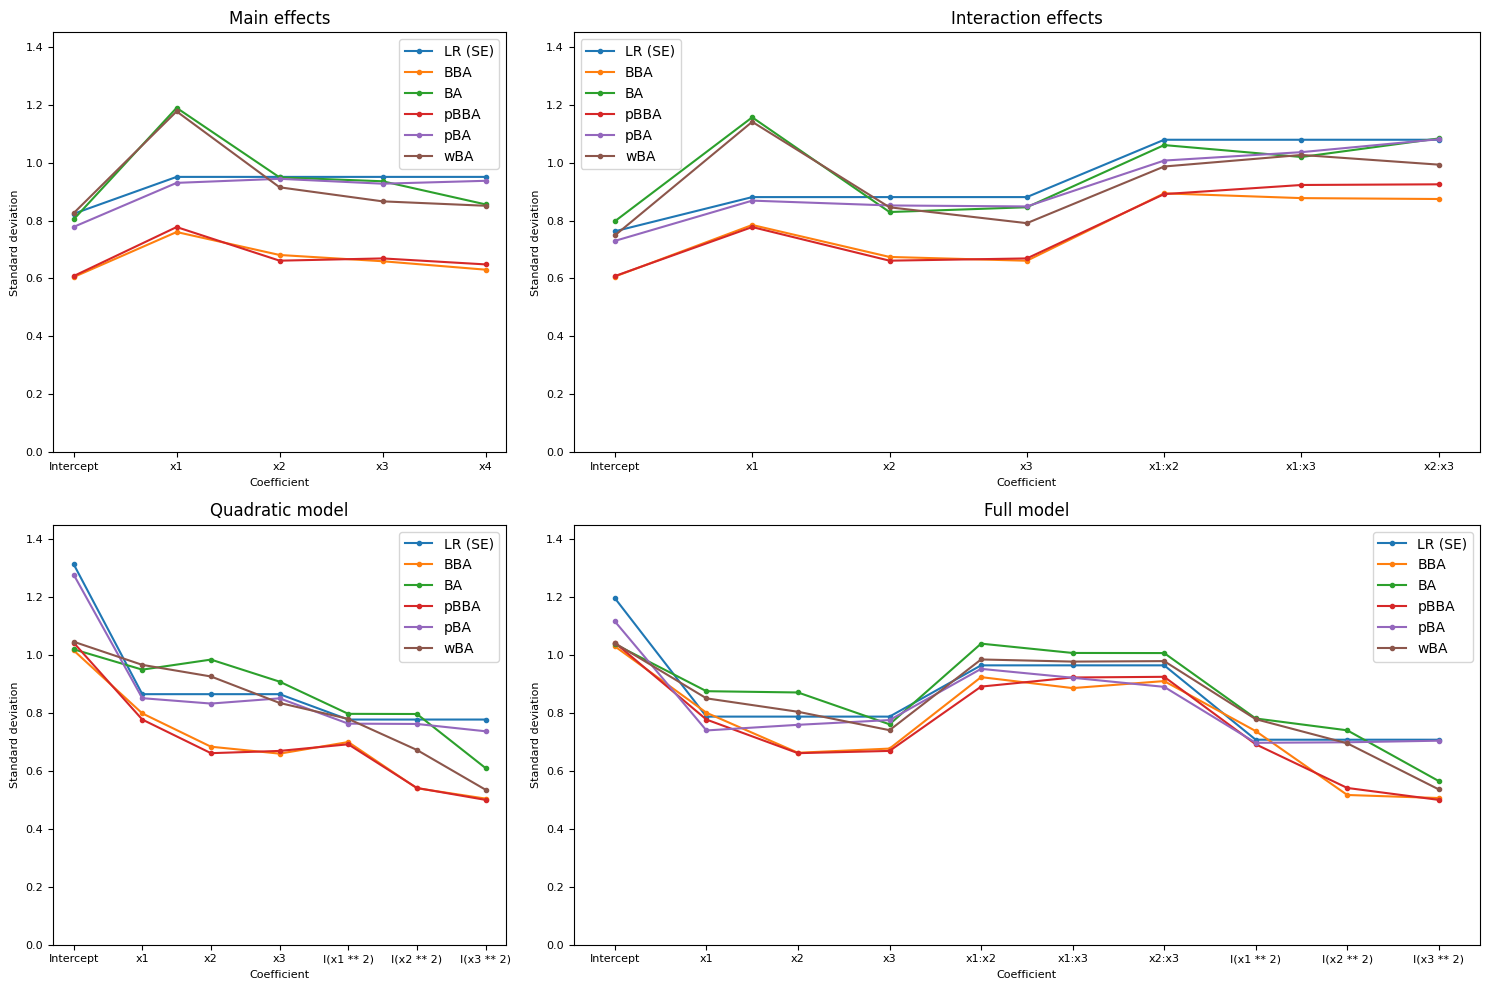

In [12]:

results = compareMethods(results, 1000)

summary_std_cofficients(results)
common.saveFigure('piston-std-1000.pdf')

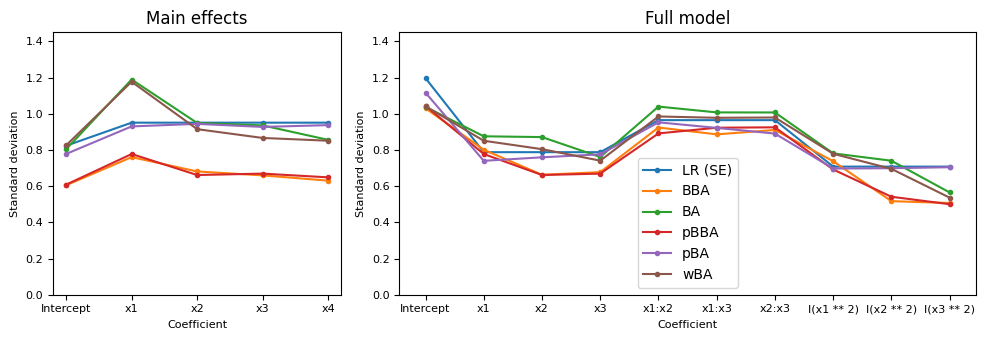

In [13]:
def summary_std_cofficients(results, plot_std_coefficients = common.plot_std_coefficients):
    yrange = (0, 1000*0.00145)
    fig, axes = plt.subplots(ncols=2, figsize=(10, 3.5), width_ratios=[1, 2])
    # axes = list(itertools.chain(*axes))

    ax = plot_std_coefficients(results['ols_main'], results['BBA_main'], results['BA_main'], 
                                    results['pBBA_main'], results['pBA_main'], results['wBA_main'], 
                                    ax=axes[0])
    ax.set_ylim(yrange)
    ax.set_title('Main effects')
    ax.get_legend().remove()
    ax = plot_std_coefficients(results['ols_full'], results['BBA_full'], results['BA_full'], 
                                    results['pBBA_full'], results['pBA_full'], results['wBA_full'], 
                                    ax=axes[1])
    ax.set_ylim(yrange)
    ax.set_title('Full model')
    ax.legend()
    plt.tight_layout()
summary_std_cofficients(results)
common.saveFigure('piston-std-1000-reduced.pdf')

In [14]:
models = {
    'main': 'Main',
    # 'interaction': 'Interaction',
    # 'quadratic': 'Quadratic',
    'full': 'Full',

}
for method in ('BBA', 'BA', 'pBBA', 'pBA', 'wBA'):
    sign_main = results['ols_main'].pvalues < 0.1
    sign_int = results['ols_interaction'].pvalues < 0.1
    comparison = pd.concat({
        v: common.calculate_Delta(results[f'ols_{k}'], results[f'{method}_{k}']) 
        for k, v in models.items()
        }, axis=1)
    comparison.columns = pd.MultiIndex.from_tuples([(x[0], method if x[1] == 'Bootstrap' else x[1]) 
                                                    for x in comparison.columns])
    styler = comparison.style
    formats = {}
    for formula in models.values():
            formats.update({
                (formula, 'Regr.'): '{:.5f}',
                (formula, method): '{:.5f}',
                (formula, 'Delta'): '{:.1f}',
            })
    styler.format(formats, na_rep='')
    def style_specific_cell(x):
        color = 'red:--rwrap;'
        df1 = pd.DataFrame('', index=x.index, columns=x.columns)
        for k, v in models.items():
            for term, pval in zip(results[f'ols_{k}'].params.index, results[f'ols_{k}'].pvalues):
                if pval > 0.1:
                    continue
                df1.loc[term, (v, 'Regr.')] = color
                df1.loc[term, (v, method)] = color
                df1.loc[term, (v, 'Delta')] = color
        return df1

    styler.apply(style_specific_cell, axis=None)

    latex = styler.to_latex(
        multicol_align="c",
        column_format='l' + 'rrr'*6,
        position_float='centering',
        hrules=True,
        label=f'tbl:piston-{method}',
        caption=f'{method} std. deviation of the regression coefficients for the Piston simulation.',
    )
    latex = latex.replace('\\begin{tabular}', '\\begin{adjustbox}{angle=90}\\begin{tabular}')
    latex = latex.replace('\\end{tabular}', '\\end{tabular}\\end{adjustbox}')
    common.saveTable(f'piston-{method}.tex', latex)
    display(styler)

In [15]:
for method in ('BBA', 'BA', 'pBBA', 'pBA', 'wBA'):
    sign_main = results['ols_main'].pvalues < 0.1
    sign_int = results['ols_interaction'].pvalues < 0.1
    comparison = pd.concat({
        v: common.calculate_Delta(results[f'ols_{k}'], results[f'{method}_{k}']) 
        for k, v in models.items()
        }, axis=1)
    comparison.columns = pd.MultiIndex.from_tuples([(x[0], method if x[1] == 'Bootstrap' else x[1]) 
                                                    for x in comparison.columns])

    styler = comparison.style
    formats = {}
    for formula in models.values():
            formats.update({
                (formula, 'Regr.'): '{:.5f}',
                (formula, method): '{:.5f}',
                (formula, 'Delta'): '{:.1f}',
            })
    
    styler.format(formats, na_rep='')

    # def style_specific_cell(x):
    #     color = 'red:--rwrap;'
    #     df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    #     for k, v in models.items():
    #         for term, pval in zip(results[f'ols_{k}'].params.index, results[f'ols_{k}'].pvalues):
    #             if pval > 0.1:
    #                 continue
    #             df1.loc[term, (v, 'Regr.')] = color
    #             df1.loc[term, (v, method)] = color
    #             df1.loc[term, (v, 'Delta')] = color
    #     return df1

    # styler.apply(style_specific_cell, axis=None)
    display(styler)

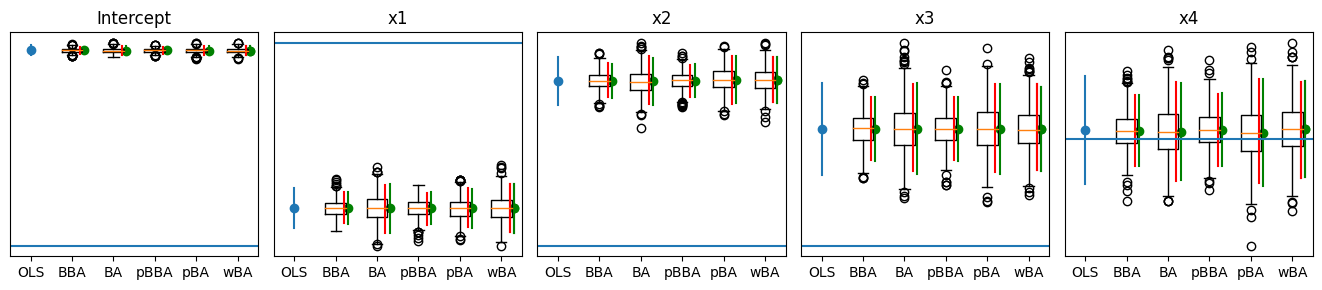

In [16]:
common.plot_coefficients(results['ols_main'], results['BBA_main'], results['BA_main'], 
                         results['pBBA_main'], results['pBA_main'], results['wBA_main'], 
                         ncols=5)
plt.tight_layout()
common.saveFigure('piston-main-dist.pdf')

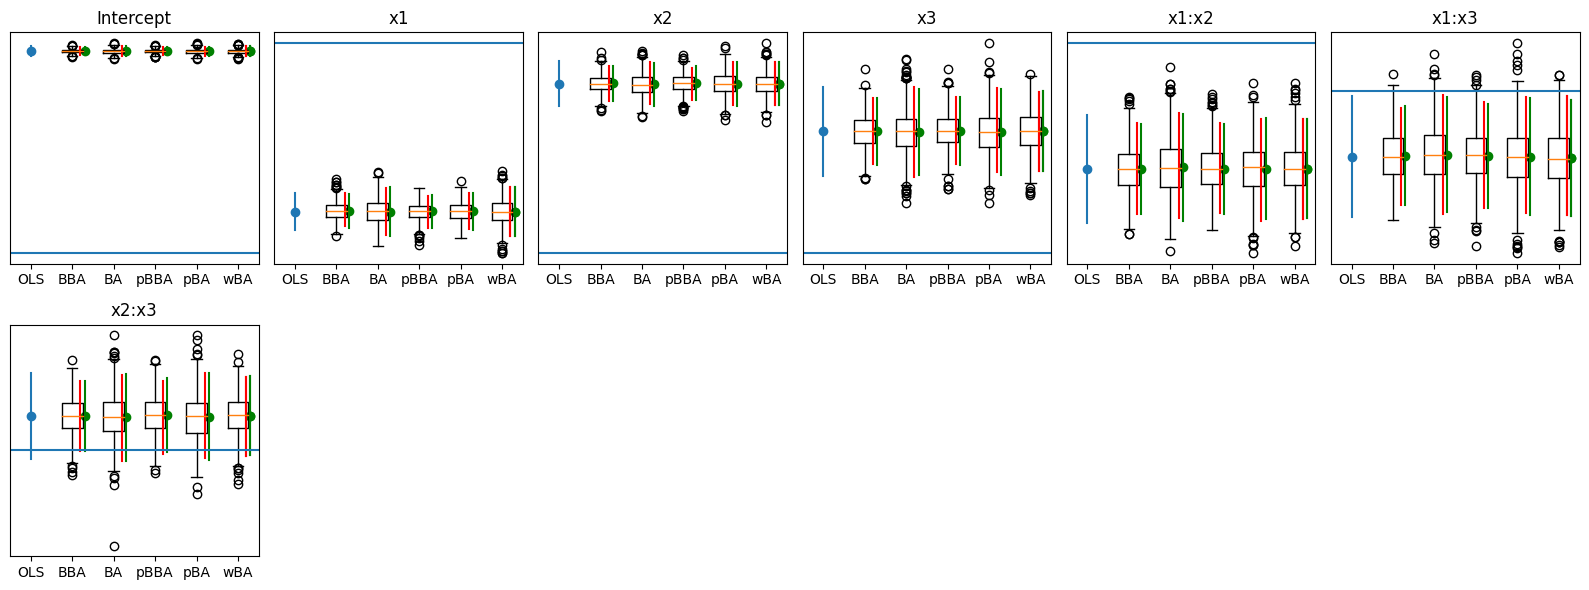

In [17]:
common.plot_coefficients(results['ols_interaction'], results['BBA_interaction'], results['BA_interaction'], 
                         results['pBBA_interaction'], results['pBA_interaction'], results['wBA_interaction'])
plt.tight_layout()
common.saveFigure('piston-int-dist.pdf')

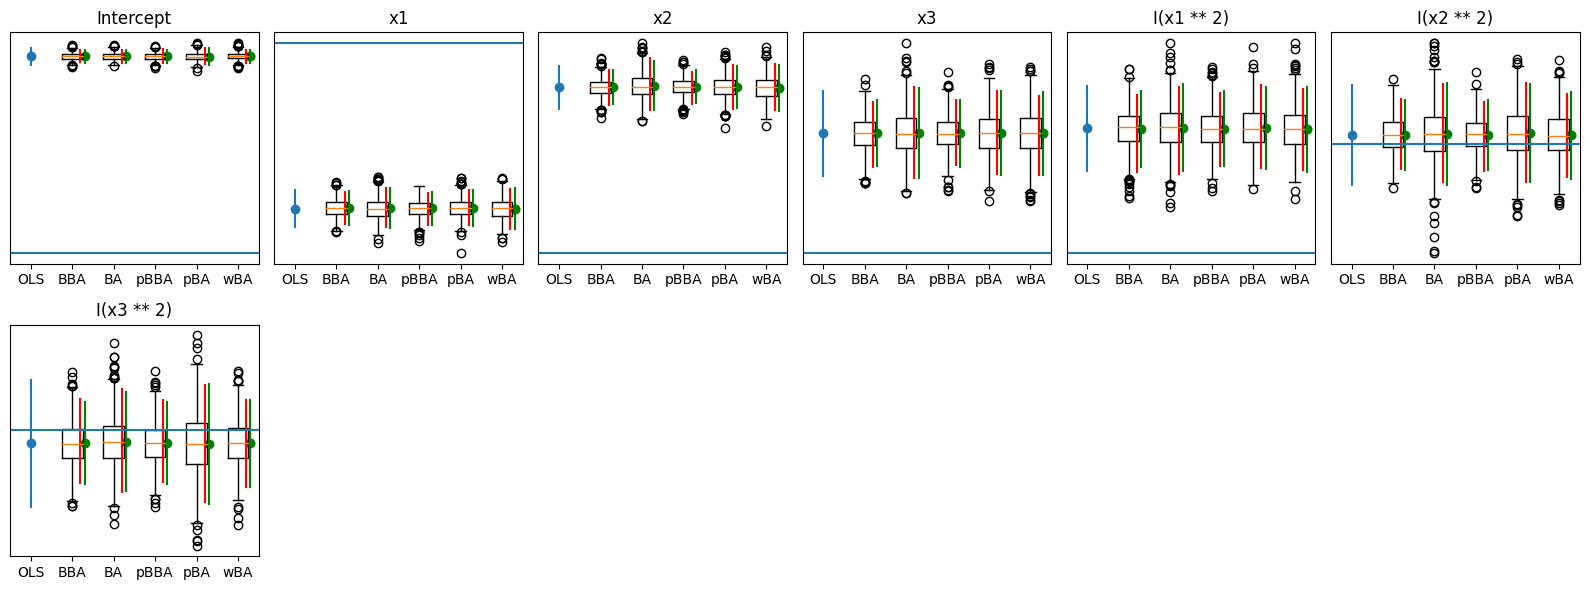

In [18]:
common.plot_coefficients(results['ols_quadratic'], results['BBA_quadratic'], results['BA_quadratic'], 
                         results['pBBA_quadratic'], results['pBA_quadratic'], results['wBA_quadratic'])
plt.tight_layout()
common.saveFigure('piston-quadratic-dist.pdf')

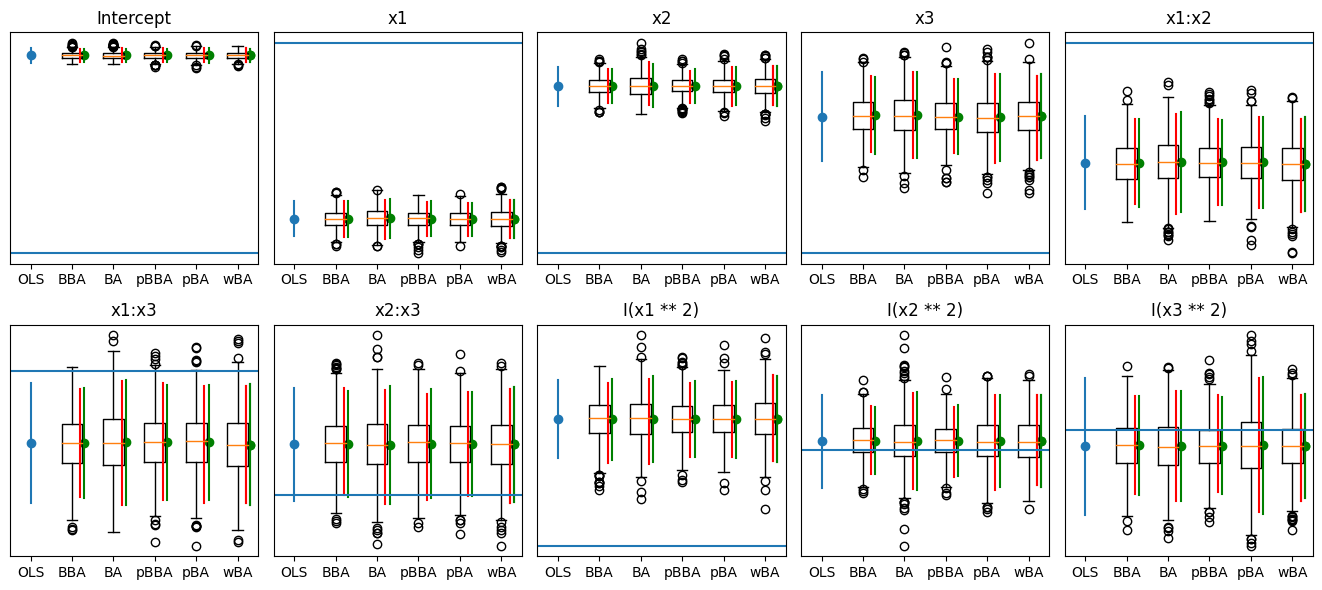

In [19]:
common.plot_coefficients(results['ols_full'], results['BBA_full'], results['BA_full'], 
                         results['pBBA_full'], results['pBA_full'], results['wBA_full'],
                        ncols=5)
plt.tight_layout()
common.saveFigure('piston-full-dist.pdf')

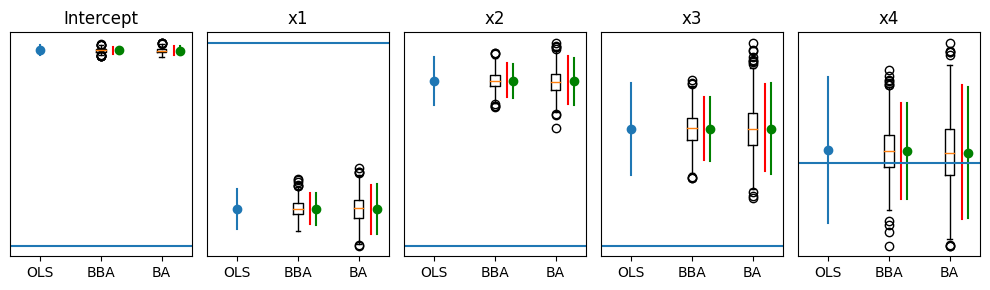

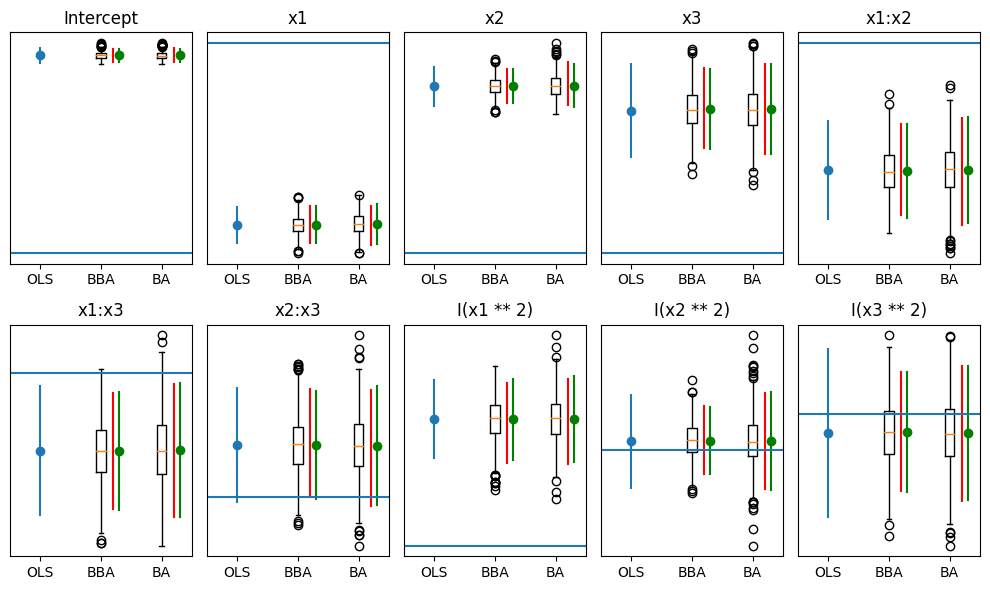

In [20]:
def plot_coefficients_main(ols_model, bba_samples, ba_samples):
    terms = list(ols_model.params.index)
    ncols = 5

    if len(terms) > ncols:
        nrows = (len(terms) - 1) // ncols + 1
        fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=[10, 3 * nrows])
        axes = itertools.chain(*axes)
    else:
        fig, axes = plt.subplots(ncols=ncols, nrows=1, figsize=[10, 3])

    for ax, term in itertools.zip_longest(axes, terms):
        if term is None:
            ax.axis('off')
            continue
        if ax is None:
            continue
        ax.plot([0, 0], [ols_model.params[term] - 1.96*ols_model.bse[term], ols_model.params[term] + 1.96*ols_model.bse[term]])
        ax.scatter(0, ols_model.params[term], )
        ax.boxplot([bba_samples[term], ba_samples[term]])

        def sample_distributions(samples, ax, offset):
            ax.plot([offset+0.2, offset+0.2], samples.quantile([0.025, 0.975]), color='red')
            m = samples.mean()
            s = samples.std() * 1.96
            ax.plot([offset+0.3, offset+0.3], [m+s, m-s], color='green')
            ax.scatter(offset+0.3, m, color='green')

        sample_distributions(bba_samples[term], ax, 1)
        sample_distributions(ba_samples[term], ax, 2)

        ax.set_title(term)
        ax.get_yaxis().set_visible(False)
        ax.set_xticks([0, 1, 2], ['OLS', 'BBA', 'BA'])
        ax.set_xlim(-0.5, 2.5)
        ax.axhline(0)

plot_coefficients_main(results['ols_main'], results['BBA_main'], results['BA_main'])
plt.tight_layout()
common.saveFigure('piston-pub-main.pdf')

plot_coefficients_main(results['ols_full'], results['BBA_full'], results['BA_full'])
plt.tight_layout()
common.saveFigure('piston-pub-full.pdf')

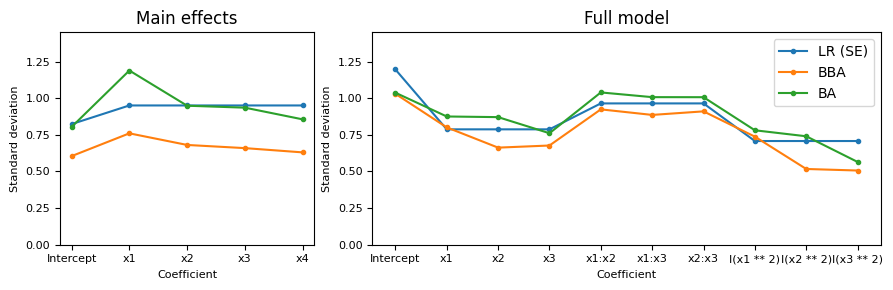

In [21]:
def plot_std_coefficients(ols_model, bba_samples, ba_samples, pbba_samples, pba_samples,
                          wba_samples, ax=None):
    std_df = pd.DataFrame({
        'LR (SE)': ols_model.bse,
        'BBA': bba_samples.agg(['mean', 'std']).transpose()['std'],
        'BA': ba_samples.agg(['mean', 'std']).transpose()['std'],
    })
    ax = std_df.plot(style='.-', ax=ax)
    ax.set_ylabel('Standard deviation')
    ax.set_xlabel('Coefficient')
    ax.set_ylim(0, std_df.max().max() * 1.05)
    ax.set_xticks(range(len(std_df)))
    ax.set_xticklabels(std_df.index)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(8)
    return ax

def summary_std_cofficients_pub(results, plot_std_coefficients = common.plot_std_coefficients):
    yrange = (0, 1000*0.00145)
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(9, 3), width_ratios=[1, 2])


    ax = plot_std_coefficients(results['ols_main'], results['BBA_main'], results['BA_main'], 
                                    results['pBBA_main'], results['pBA_main'], results['wBA_main'], 
                                    ax=axes[0])
    ax.set_ylim(yrange)
    ax.set_title('Main effects')
    ax.get_legend().remove()
    ax = plot_std_coefficients(results['ols_full'], results['BBA_full'], results['BA_full'], 
                                    results['pBBA_full'], results['pBA_full'], results['wBA_full'], 
                                    ax=axes[1])
    ax.set_ylim(yrange)
    ax.set_title('Full model')
    ax.legend()
    plt.tight_layout()


summary_std_cofficients_pub(results, plot_std_coefficients=plot_std_coefficients)
common.saveFigure('piston-pub-std-coefficients.pdf')